<a href="https://colab.research.google.com/github/profedaniel86/Series_de_Tiempo/blob/main/4.%20Protocolos_Bayes/Arima_bayes_ventana.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fundamentos de analítica 2 -Aprendizaje Automatico III (clase 2)

## Diego Fernando Agudelo - Daniel Felipe Osorio
## Universidad ICESI
## diegoagudelo30@gmail.com - dfosorio@icesi.edu.co

## **1. Carga de paquetes**

In [2]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 6.3 MB/s eta 0:00:00


In [3]:

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

import numpy as np
import optuna
import numpy as np
import pandas as pd
import warnings
import optuna

import matplotlib.pyplot as plt



## **2. Datos**

In [4]:

np.random.seed(42)
n = 300
t = np.arange(n)

# Ruido con varianza creciente
ruido = np.random.normal(0, 1 + 0.01 * t)

# Tendencia con ruptura
tendencia = np.piecewise(t,
                         [t < 100, (t >= 100) & (t < 200), t >= 200],
                         [lambda t: 0.05 * t,
                          lambda t: 0.3 * (t - 100) + 5,
                          lambda t: -0.1 * (t - 200) + 35])

# Estacionalidad con cambio de periodo
estacionalidad = np.piecewise(t,
                               [t < 150, t >= 150],
                               [lambda t: 5 * np.sin(2 * np.pi * t / 30),
                                lambda t: 2 * np.sin(2 * np.pi * t / 15)])

# Serie total
serie = tendencia + estacionalidad + ruido
serie = pd.Series(serie, index=pd.date_range("2020-01-01", periods=n, freq='D'))




## **3. Visualización Serie**

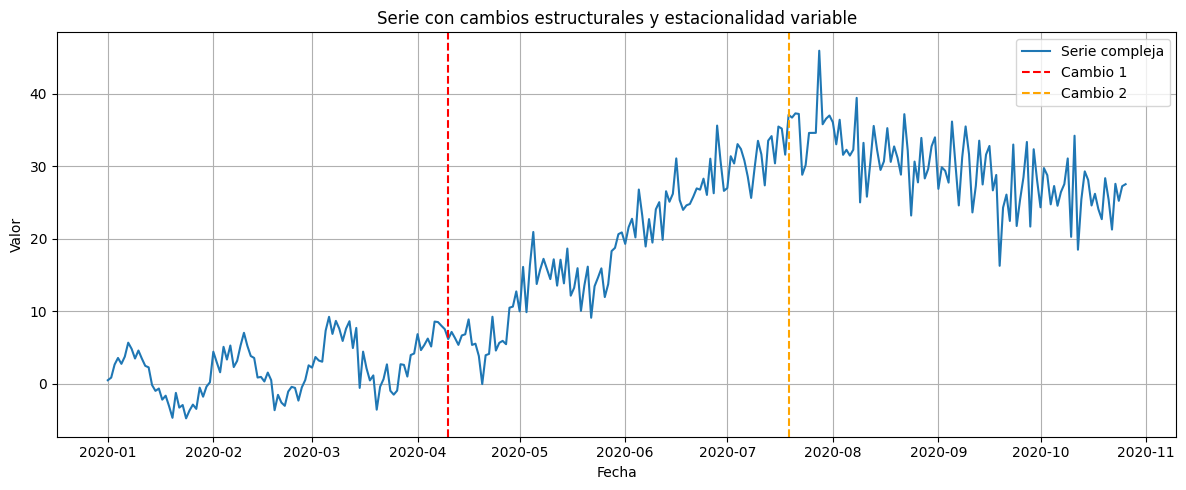

In [5]:
plt.figure(figsize=(12, 5))
plt.plot(serie, label="Serie compleja")
plt.axvline(serie.index[100], color='red', linestyle='--', label="Cambio 1")
plt.axvline(serie.index[200], color='orange', linestyle='--', label="Cambio 2")
plt.title("Serie con cambios estructurales y estacionalidad variable")
plt.xlabel("Fecha")
plt.ylabel("Valor")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## **4. Función Entrenamiento**

In [10]:
def evaluar_expanding_forecast(serie, order, window=12, step_size=1, horizon=1, metric='rmse'):
    """
    Simula pronósticos autoregresivos en tiempo real con ventana expandida desde el inicio.

    Parámetros:
        serie     : serie temporal (pd.Series o array-like)
        order     : tupla ARIMA (p,d,q)
        window    : cantidad de pronósticos (desde el final hacia atrás)
        step_size : cada cuántos puntos se hace un pronóstico
        horizon   : cuántos pasos adelante predices en cada punto
        metric    : 'rmse' o 'mae'

    Retorna:
        Error promedio global (RMSE o MAE) entre todos los valores predichos vs observados.
    """

    # Asegurar tipo y limpiar NaN de la serie
    serie = pd.Series(serie).astype(float).dropna()

    n = len(serie)
    predichos = []
    observados = []

    # índices donde termina el conjunto de entrenamiento
    puntos_finales = list(range(n - window * step_size, n - horizon + 1, step_size))

    for end_train in puntos_finales:
        train = serie.iloc[:end_train]
        test = serie.iloc[end_train:end_train + horizon]

        if len(test) < horizon:
            continue

        # Si el test ya tiene NaN, lo ignoramos
        if test.isna().any():
            continue

        try:
            model = ARIMA(
                train,
                order=order,
                enforce_stationarity=False,
                enforce_invertibility=False
            ).fit()

            pred = model.forecast(steps=horizon)

        except Exception:
            # Si falla el ajuste o el forecast, pasamos a la siguiente ventana
            continue

        # Convertir a Series y filtrar NaN en predicciones
        pred = pd.Series(pred).astype(float)

        # Máscara conjunta para asegurar que ni observados ni predichos tengan NaN
        mask = (~pred.isna()) & (~test.isna())

        if mask.sum() == 0:
            continue

        predichos.extend(pred[mask].tolist())
        observados.extend(test[mask].tolist())

    if len(predichos) == 0:
        return np.inf

    predichos = np.array(predichos, dtype=float)
    observados = np.array(observados, dtype=float)

    mask_finite = (
        np.isfinite(predichos) &
        np.isfinite(observados)
    )

    if mask_finite.sum() == 0:
        return np.inf

    predichos = predichos[mask_finite]
    observados = observados[mask_finite]

    # Cálculo de la métrica
    if metric == 'rmse':
        return np.sqrt(mean_squared_error(observados, predichos))
    elif metric == 'mae':
        return np.mean(np.abs(observados - predichos))
    else:
        raise ValueError("Metric must be 'rmse' or 'mae'")


## **5. Optimización Bayesiana**

In [11]:
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

def objective(trial):

    p = trial.suggest_int("p", 1, 10)
    d = trial.suggest_int("d", 1, 2)
    q = trial.suggest_int("q", 1, 10)

    order = (p, d, q)
    return evaluar_expanding_forecast(serie, order, window=12, step_size=1, horizon=2)


study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20 )

[I 2025-11-14 19:50:49,724] A new study created in memory with name: no-name-38456314-a0b0-4bf8-b0a6-7e6c3e53e768
[I 2025-11-14 19:50:51,813] Trial 0 finished with value: 2.4933308235369602 and parameters: {'p': 1, 'd': 1, 'q': 4}. Best is trial 0 with value: 2.4933308235369602.
[I 2025-11-14 19:50:53,305] Trial 1 finished with value: 2.545658199038675 and parameters: {'p': 4, 'd': 1, 'q': 1}. Best is trial 0 with value: 2.4933308235369602.
[I 2025-11-14 19:51:01,669] Trial 2 finished with value: 2.2479677750929112 and parameters: {'p': 8, 'd': 1, 'q': 2}. Best is trial 2 with value: 2.2479677750929112.
[I 2025-11-14 19:51:10,405] Trial 3 finished with value: 2.4683029868168664 and parameters: {'p': 5, 'd': 2, 'q': 2}. Best is trial 2 with value: 2.2479677750929112.
[I 2025-11-14 19:51:41,155] Trial 4 finished with value: 2.2829628580518104 and parameters: {'p': 2, 'd': 2, 'q': 10}. Best is trial 2 with value: 2.2479677750929112.
[I 2025-11-14 19:51:45,983] Trial 5 finished with value:

## Taller en Clase: Pronóstico del Número de Ocupados
### Objetivo del taller:

Empleando la información del número de ocupados (en miles de personas) para las 13 principales ciudades del país, construya un modelo de pronóstico para los próximos 6 meses utilizando los métodos de suavización exponencial vistos en clase, considerando versiones aditivas o multiplicativas según la naturaleza de la serie. Para ajustar los hiperparámetros del modelo (como alpha, beta y gamma), utilice optimización bayesiana a través de la librería Optuna, definiendo un espacio de búsqueda adecuado. La evaluación del modelo debe realizarse mediante un protocolo de validación temporal, utilizando una ventana móvil o recursiva, y empleando métricas apropiadas como RMSE.

Una vez ajustado el modelo, compárelo con el mejor modelo obtenido en el ejercicio anterior. Luego, elabore un informe breve (máximo una página de texto) explicando  los resultados obtenidos y las proyecciones generadas, incluyendo las predicciones para los próximos 6 meses, mencione las principales limitaciones del pronóstico.

